# 주택 가격 예측하기

In [30]:
from keras.datasets import boston_housing

In [31]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [32]:
print(train_data.shape) #13개의 수치특성
print(test_data.shape)
print(train_targets.shape)

(404, 13)
(102, 13)
(404,)


**상이한 스케일을 신경망에 주입하면 문제가 생김 >> 정규화**

In [33]:
mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data/= std

test_data -= mean
test_data /= std

In [34]:
from keras import models
from keras import layers

In [35]:
def build_model(): #동일  모델 여러 번 생성할 것이므로 함수 생성
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1)) #회귀 문제
    
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae']) #모니터링위해 평균 절대 오차 사용 (예측과 타깃 사이 거리 절대값)
    return model

# k-fold cross-validation사용한 훈련 검증

**데이터가 많지 않기 때문에 신뢰있는 모델 만들 수가 없음**

**데이터를 k개로 분할하고 k개의 모델을 각각 만들어 k-1개의 분할에서 훈련하고 나머지에서 평가**

**검증 점수는 k개의 검증 점수 평균**

In [36]:
import numpy as np

In [37]:
k = 4
num_val_samples = len(train_data) //k
num_epochs = 100
all_scores = []
for i in range(k):
    print("처리 중인 폴드 : #{}".format(i)) 
    val_data = train_data[i * num_val_samples : (i+1)*num_val_samples] #검증 데이터 준비 : k번째 분할
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(              #훈련 데이터 준비 : 다른 분할 전체
        [train_data[:i * num_val_samples], 
         train_data[(i+1) * num_val_samples:]], axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], 
         train_targets[(i+1) * num_val_samples:]], axis = 0)
    
    model = build_model() #모델 구성, 컴파일
    model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1, verbose = 0) #verbose 가 0이면 훈련과정 출력 x
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)

처리 중인 폴드 : #0
처리 중인 폴드 : #1
처리 중인 폴드 : #2
처리 중인 폴드 : #3


In [38]:
history.history.keys()

dict_keys(['loss', 'mae'])

In [39]:
all_scores #2.2 부터 2.6까지 변화

[2.104081153869629, 2.4482250213623047, 2.8135740756988525, 2.208004951477051]

In [40]:
np.mean(all_scores) #평균 : 2.4 >>  평균적으로 2400달러 차이가 남

2.3934713006019592

In [41]:
num_epochs = 500 #epochs = 500으로 늘려본다.
all_mae_histories = []
for i in range(k):
    print("처리 중인 폴드 : #{}".format(i)) 
    val_data = train_data[i * num_val_samples : (i+1)*num_val_samples] #검증 데이터 준비 : k번째 분할
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(              #훈련 데이터 준비 : 다른 분할 전체
        [train_data[:i * num_val_samples], 
         train_data[(i+1) * num_val_samples:]], axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], 
         train_targets[(i+1) * num_val_samples:]], axis = 0)
    
    model = build_model() 
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data = (val_data, val_targets),
                        epochs = num_epochs, batch_size = 1, verbose = 0) #verbose 가 0이면 훈련과정 출력 x
    mae_history = history.history['mae']
    
    all_mae_histories.append(mae_history)

처리 중인 폴드 : #0
처리 중인 폴드 : #1
처리 중인 폴드 : #2
처리 중인 폴드 : #3


In [47]:
average_mae_histories = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

In [48]:
import matplotlib.pyplot as plt

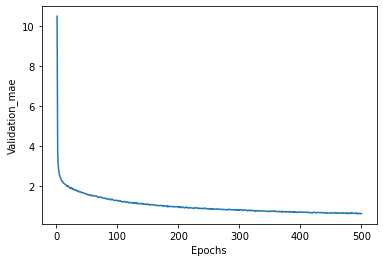

In [50]:
plt.plot(range(1, len(average_mae_histories)+1), average_mae_histories)
plt.xlabel('Epochs')
plt.ylabel('Validation_mae')
plt.show()

**곡선의 다른 부분과 스케일이 다른 10개의 데이터 제외**

In [52]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

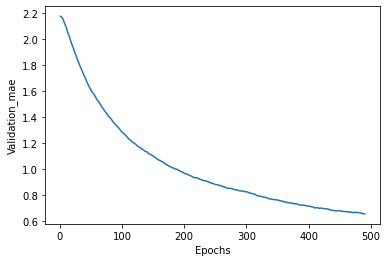

In [56]:
smooth_mae_history = smooth_curve(average_mae_histories[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation_mae')
plt.show()